# Trabalho de Conclusão de Curso
### Ciência de Dados e Big Data - PUC-MG - 2021
### Aluno: Renan Vercezi Rossato
### Título: Previsão de resultados nas partidas da Premier League
###  


# Sumário

## 1. Definição de funções necessárias
## 2. Processamento dos dados
## 3. Análise e Exploração dos dados 
## 4. Criação dos modelos de Machine Learning
##  


In [ ]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib as mpl

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn import feature_selection
from sklearn import tree

# 1. Definição de funções necessárias

In [2]:
#Remover variáveis desnecessárias
def remover_var_desnec(df):                                                   
    df = df.drop(df.columns[23:200], axis=1)
    df = df.drop(columns=['Div', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HST', 
                          'AST', 'HS', 'AS', 'HY', 'AY', 'HR', 'AR'])
    return df

#Listas todos os times da temporada
def listar_times(df):                                 
    teams_list = df['HomeTeam'].unique()
    return teams_list

#Mapear o atributo 'FTR' para ser binário (apenas H e NH)
def mapear_resultados(df):                            
#    map_FTR = {'H':'H', 'A':'NH', 'D':'NH'}
    map_FTR = {'H':1, 'A':0, 'D':0}    
    df['FTR_H_NH'] = df['FTR'].map(map_FTR)
    return df

#Criar variável com o número da rodada
def numero_rodada_T():
    df['Round_Home_T'] = ''
    df['Round_Away_T'] = ''
    
    for i in range(len(df)):
        rodada = df.loc[:i]['HomeTeam'].str.count(df.loc[i]['HomeTeam']).sum() + df.loc[:i]['AwayTeam'].str.count(df.loc[i]['HomeTeam']).sum()
        df.loc[i,'Round_Home_T'] = rodada
        
    for i in range(len(df)):
        rodada = df.loc[:i]['HomeTeam'].str.count(df.loc[i]['AwayTeam']).sum() + df.loc[:i]['AwayTeam'].str.count(df.loc[i]['AwayTeam']).sum()
        df.loc[i,'Round_Away_T'] = rodada        
    
    return df

#Criar variável com o número da rodada do time mandante e do time visitante
def numero_rodada_HA(df, teams_list):                              
    serie_home = pd.Series(dtype = 'int')
    for team in teams_list:
        serie_aux = df['HomeTeam'][df['HomeTeam'] == team].apply(lambda x: 1 if x == team else 0).cumsum()
        serie_home = serie_home.append(serie_aux)

    serie_away = pd.Series(dtype = 'int')
    for team in teams_list:
        serie_aux = df['AwayTeam'][df['AwayTeam'] == team].apply(lambda x: 1 if x == team else 0).cumsum()
        serie_away = serie_away.append(serie_aux)

    df['Round_Home_H'] = serie_home
    df['Round_Away_A'] = serie_away
    return df

#Função para mapear os resultados (W, D e L) e a pontuação de cada time em cada rodada
def mapear_resultados_T(df, time):                      
    if df['HomeTeam'] == time:
        if df['FTR'] == 'H':
            result = 'W'
            pts = 3
        elif df['FTR'] == 'D':
            result = 'D'
            pts = 1
        else:
            result = 'L'
            pts = 0
    elif df['AwayTeam'] == time:
        if df['FTR'] == 'H':
            result = 'L'
            pts = 0
        elif df['FTR'] == 'D':
            result = 'D'
            pts = 1
        else:
            result = 'W'
            pts = 3
            
    return pd.Series([result, pts])

#Aplicar a função 'mapear_resultados' para cada time e criar dataframes auxiliares de resultados e pontuação
def resultados_T(df, lista_times):                                        
    d_result = {}
    d_pts = {}
    d_pts_cum = {}
    
    for time in lista_times:       
        df_time = df[(df['HomeTeam'] == time) | (df['AwayTeam'] == time)]
        df_time[['Result', 'Pts']] = df_time.apply(mapear_resultados_T, args=(time, ), axis=1)
        #Resultado do time V, D ou L
        d_result[time] = df_time['Result'].tolist()
        #Quantidade de pontos ganhos na rodada
        d_pts[time] = df_time['Pts'].tolist()
        #Pontos acumulados nas rodadas --> para calcular a pontuação média por rodada
        d_pts_cum[time] = df_time['Pts'].cumsum().tolist()
         
    df_aux1 = pd.DataFrame.from_dict(d_result, orient='index')
    df_aux2 = pd.DataFrame.from_dict(d_pts, orient='index')
    df_aux3 = pd.DataFrame.from_dict(d_pts_cum, orient='index')
    
    df_aux1.columns = df_aux1.columns + 1
    df_aux2.columns = df_aux2.columns + 1    
    df_aux3.columns = df_aux3.columns + 1 
    
    df_aux3 = (df_aux3/df_aux3.columns).round(1)
    
    return df_aux1, df_aux2, df_aux3

#Função para mapear os resultados (W, D e L) e a pontuação de cada time em cada rodada atuando como mandante ou visitante
def mapear_resultados_HA(df, time, home_away):                      
    if df[home_away] == time:
        if home_away == 'HomeTeam':
            if df['FTR'] == 'H':
                result = 'W'
                pts = 3
            elif df['FTR'] == 'D':
                result = 'D'
                pts = 1
            else:
                result = 'L'
                pts = 0
            gols_dif = df['FTHG'] - df['FTAG']
            fouls_dif = df['HF'] - df['AF']
            corners_dif = df['HC'] - df['AC']
        elif home_away == 'AwayTeam':
            if df['FTR'] == 'A':
                result = 'W'
                pts = 3
            elif df['FTR'] == 'D':
                result = 'D'
                pts = 1
            else:
                result = 'L'
                pts = 0
            gols_dif = df['FTAG'] - df['FTHG']   
            fouls_dif = df['AF'] - df['HF']
            corners_dif = df['AC'] - df['HC']
            
    return pd.Series([result, pts, gols_dif, fouls_dif, corners_dif])

#Aplicar a função 'mapear_resultados' para cada time e criar dataframes auxiliares de resultados e pontuação
def resultados_HA(df, home_away, lista_times):                                        
    d_result = {}
    d_pts = {}
    d_gols_dif = {}
    d_fouls_dif = {}
    d_corners_dif = {}
    d_pts_cum = {}
    d_gols_dif_cum = {}
    d_fouls_dif_cum = {}
    d_corners_dif_cum = {}
    
    for time in lista_times:       
        df_time = df[df[home_away] == time]
        df_time[['Result', 'Pts', 'DifGols', 'DifFouls', 'DifCorners']] = df_time.apply(mapear_resultados_HA, args=(time, home_away, ), axis=1)
        #Resultado do time V, D ou L
        d_result[time] = df_time['Result'].tolist()
        #Quantidade de pontos ganhos na rodada
        d_pts[time] = df_time['Pts'].tolist()
        #Diferença de gols na rodada
        d_gols_dif[time] = df_time['DifGols'].tolist()
        #Quantidade de chutes a gol na rodada
        d_fouls_dif[time] = df_time['DifFouls'].tolist()
        #Quantidade de escanteios na rodada
        d_corners_dif[time] = df_time['DifCorners'].tolist()       
        #Pontos acumulados nas rodadas --> para calcular a pontuação média por rodada
        d_pts_cum[time] = df_time['Pts'].cumsum().tolist()
        #Diferença de gols acumulada nas rodadas --> para calcular a diferença de gols média na rodada
        d_gols_dif_cum[time] = df_time['DifGols'].cumsum().tolist()
        #Chutes a gol acumulados nas rodadas --> para calcular a quantidade média de chutes por rodada
        d_fouls_dif_cum[time] = df_time['DifFouls'].cumsum().tolist()
        #Escanteios acumulados nas rodadas --> para calcular a quantidade média de escanteios na rodada
        d_corners_dif_cum[time] = df_time['DifCorners'].cumsum().tolist()       
        
    df_aux1 = pd.DataFrame.from_dict(d_result, orient='index')
    df_aux2 = pd.DataFrame.from_dict(d_pts, orient='index')
    df_aux3 = pd.DataFrame.from_dict(d_gols_dif, orient='index')
    df_aux4 = pd.DataFrame.from_dict(d_fouls_dif, orient='index')
    df_aux5 = pd.DataFrame.from_dict(d_corners_dif, orient='index')   
    df_aux6 = pd.DataFrame.from_dict(d_pts_cum, orient='index')
    df_aux7 = pd.DataFrame.from_dict(d_gols_dif_cum, orient='index')  
    df_aux8 = pd.DataFrame.from_dict(d_fouls_dif_cum, orient='index')
    df_aux9 = pd.DataFrame.from_dict(d_corners_dif_cum, orient='index') 
    
    df_aux1.columns = df_aux1.columns + 1
    df_aux2.columns = df_aux2.columns + 1
    df_aux3.columns = df_aux3.columns + 1
    df_aux4.columns = df_aux4.columns + 1
    df_aux5.columns = df_aux5.columns + 1    
    df_aux6.columns = df_aux6.columns + 1
    df_aux7.columns = df_aux7.columns + 1
    df_aux8.columns = df_aux8.columns + 1
    df_aux9.columns = df_aux9.columns + 1    
    
    df_aux6 = (df_aux6/df_aux6.columns).round(1)
    df_aux7 = (df_aux7/df_aux7.columns).round(1)
    df_aux8 = (df_aux8/df_aux8.columns).round(1)
    df_aux9 = (df_aux9/df_aux9.columns).round(1)

    return df_aux1, df_aux2, df_aux3, df_aux4, df_aux5, df_aux6, df_aux7, df_aux8, df_aux9

#Criar variável com a média de pontos do time mandante considerando todas as rodadas anteriores
def HTPts_T(df, df_pts_cum_T):           
    rodada = df['Round_Home_T']
    if rodada - 1 > 0:
        time = df['HomeTeam']
        pts_cum = df_pts_cum_T.loc[time, rodada-1]     
        return pd.Series([pts_cum])
    else:
        return pd.Series([0])

#Criar variável com a média de pontos do time visitante considerando todas as rodadas anteriores   
def ATPts_T(df, df_pts_cum_T):           
    rodada = df['Round_Away_T']
    if rodada - 1 > 0:
        time = df['AwayTeam']
        pts_cum = df_pts_cum_T.loc[time, rodada-1]     
        return pd.Series([pts_cum])
    else:
        return pd.Series([0])   

#Criar variáveis de média de pontos, média de diferença de gols, faltas e escanteios do time mandante atuando como mandante
def HTPts_H_HTGDif_H(df, df_H_pts_cum, df_H_gols_dif_cum, df_H_fouls_cum, df_H_corners_cum):
    rodada = df['Round_Home_H']
    if rodada - 1 > 0:
        time = df['HomeTeam']
        pts_cum = df_pts_cum_H.loc[time, rodada-1]
        gols_dif_cum = df_gols_dif_cum_H.loc[time, rodada-1]
        fouls_dif_cum = df_fouls_dif_cum_H.loc[time, rodada-1]
        corners_dif_cum = df_corners_dif_cum_H.loc[time, rodada-1]        
        return pd.Series([pts_cum, gols_dif_cum, fouls_dif_cum, corners_dif_cum])
    else:
        return pd.Series([0, 0,0,0])

#Criar variáveis de média de pontos, média de diferença de gols, faltas e escanteios do time visitante atuando como visitante
def ATPts_A_ATGDif_A(df, df_A_pts_cum, df_A_gols_dif_cum, df_A_fouls_cum, df_A_corners_cum):
    rodada = df['Round_Away_A']
    if rodada - 1 > 0:
        time = df['AwayTeam']
        pts_cum = df_pts_cum_A.loc[time, rodada-1]
        gols_dif_cum = df_gols_dif_cum_A.loc[time, rodada-1]
        fouls_dif_cum = df_fouls_dif_cum_A.loc[time, rodada-1]
        corners_dif_cum = df_corners_dif_cum_A.loc[time, rodada-1]        
        return pd.Series([pts_cum, gols_dif_cum, fouls_dif_cum, corners_dif_cum])
    else:
        return pd.Series([0,0,0,0])
    
#Criar variáveis auxiliares com o resultado obtido nas últimas 3 partidas do time mandante
def HM(df, n_rodadas):                              
    time = df['HomeTeam']
    rodada = df['Round_Home_T']
    return df_result_T.loc[time, rodada - n_rodadas]

def HM_rodadas(df, n_rodadas):
    df['HTM'+str(n_rodadas)+'_T'] = df[df['Round_Home_T']> n_rodadas].apply(HM, args=(n_rodadas, ), axis=1)
     
#Criar variáveis auxiliares com o resultado obtido nas últimas 3 partidas do time visitante
def AM(df, n_rodadas):
    time = df['AwayTeam']
    rodada = df['Round_Away_T']
    return df_result_T.loc[time, rodada - n_rodadas]

def AM_rodadas(df, n_rodadas):
    df['ATM'+str(n_rodadas)+'_T'] = df[df['Round_Away_T']> n_rodadas].apply(AM, args=(n_rodadas, ), axis=1)
    
#Função para calcular a pontuação nas últimas 3 rodadas
def H_FormPts(df):
    pts = 0
    v_count = 0
    d_count = 0
    for i in range(3):
        if df['HTM'+str(i+1)+'_T'] == 'W':
            v_count = v_count+1
        if df['HTM'+str(i+1)+'_T'] == 'D':
            d_count = d_count+1
    pts = v_count*3 + d_count*1
    return pts/3
        
def A_FormPts(df):
    pts = 0
    v_count = 0
    d_count = 0
    for i in range(3):
        if df['ATM'+str(i+1)+'_T'] == 'W':
            v_count = v_count+1
        if df['ATM'+str(i+1)+'_T'] == 'D':
            d_count = d_count+1
    pts = v_count*3 + d_count*1
    return pts/3

#Remover 3 primeiras rodadas
def remover_prim3(df):
    df_pos3 = df[(df['Round_Home_T'] > 3) & (df['Round_Away_T'] > 3)]   
    return df_pos3

#Remover variáveis auxiliares utilizadas
def remover_var_aux(df):
    df = df.drop(columns=['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'HF', 'AF', 'HC', 'AC',
                          'FTAG', 'FTR', 'Round_Home_T', 'Round_Away_T', 'Round_Home_H',
                          'Round_Away_A', 'HTM1_T', 'HTM2_T', 'HTM3_T', 'ATM1_T', 'ATM2_T', 'ATM3_T'])    
    
    df = df.astype({'HTPts_H': 'float',
                    'HTGDif_H': 'float',
                    'HTFDif_H': 'float',
                    'HTEDif_H': 'float',
                    'ATPts_A': 'float',
                    'ATGDif_A': 'float',
                    'ATFDif_A': 'float',
                    'ATEDif_A': 'float',
                    'HTPts_T': 'float',
                    'ATPts_T': 'float',
                    'HT3MPts_T': 'float',
                    'AT3MPts_T': 'float'                    
                    })

    return df

In [3]:
#Diretório onde estão salvos os arquivos obtidos das partidas de cada temporada
diretorio = "D:/_Pós PUC-MG/_TCC/Banco_de_Dados - Futebol/"

#Lista dos arquivos das temporadas
arquivos = ['Premier_League_2013_2014.csv',
            'Premier_League_2014_2015.csv',
            'Premier_League_2015_2016.csv',
            'Premier_League_2016_2017.csv',
            'Premier_League_2017_2018.csv',
            'Premier_League_2018_2019.csv',
            'Premier_League_2019_2020.csv'
           ]

# 2. Processamento dos dados

In [4]:
#Definição de loop para processar e tratar is dados de cada temporada e compilar em um único dataset

#Ocultar warnings indevidos
pd.options.mode.chained_assignment = None

df_completo_pos3 = pd.DataFrame()

for arquivo in arquivos:
    
    print(arquivo)
    
    lista_times = []
      
    df = pd.read_csv(diretorio+arquivo)
    
    if 'Time' in df.columns:
        df = df.drop(columns=['Time'])
    
    df = remover_var_desnec(df)
    
    df['Temporada'] = arquivo[15:24]

    df = mapear_resultados(df)

    lista_times = listar_times(df)
    
    df = numero_rodada_T()

    df = numero_rodada_HA(df, lista_times)
    
    #INICIO - Criar Tabelas Auxiliares    
    df_result_T, df_pts_T, df_pts_cum_T = resultados_T(df, lista_times)
    
    df_result_H, df_pts_H, df_gols_dif_H, df_fouls_dif_H, df_corners_dif_H, df_pts_cum_H, df_gols_dif_cum_H, df_fouls_dif_cum_H, df_corners_dif_cum_H = resultados_HA(df, 'HomeTeam', lista_times)
    
    df_result_A, df_pts_A, df_gols_dif_A, df_fouls_dif_A, df_corners_dif_A, df_pts_cum_A, df_gols_dif_cum_A, df_fouls_dif_cum_A, df_corners_dif_cum_A = resultados_HA(df, 'AwayTeam', lista_times)
    #FIM - Criar Tabelas Auxiliares
    
    df[['HTPts_T']] = df.apply(HTPts_T, args=(df_pts_cum_T, ), axis=1)
    df[['ATPts_T']] = df.apply(ATPts_T, args=(df_pts_cum_T, ), axis=1)

    df[['HTPts_H','HTGDif_H','HTFDif_H','HTEDif_H']] = df.apply(HTPts_H_HTGDif_H, args=(df_pts_cum_H, df_gols_dif_cum_H, df_fouls_dif_cum_H, df_corners_dif_cum_H), axis=1)
    df[['ATPts_A','ATGDif_A','ATFDif_A','ATEDif_A']] = df.apply(ATPts_A_ATGDif_A, args=(df_pts_cum_A, df_gols_dif_cum_A, df_fouls_dif_cum_A, df_corners_dif_cum_A), axis=1)
    
    for i in range(3):
        HM_rodadas(df, i+1)    
    for i in range(3):
        AM_rodadas(df, i+1)
    df = df.fillna('-')

    df['HT3MPts_T'] = (df.apply(H_FormPts, axis=1)).round(1)
    df['AT3MPts_T'] = (df.apply(A_FormPts, axis=1)).round(1)
    
    df_pos3 = remover_prim3(df)
    
    df_pos3 = remover_var_aux(df_pos3)
        
    df_completo_pos3 = pd.concat([df_completo_pos3, df_pos3])
    
df_completo_pos3 = df_completo_pos3.reset_index(drop = True)

Premier_League_2013_2014.csv
Premier_League_2014_2015.csv
Premier_League_2015_2016.csv
Premier_League_2016_2017.csv
Premier_League_2017_2018.csv
Premier_League_2018_2019.csv
Premier_League_2019_2020.csv


# 3. Análise e Exploração dos dados

In [5]:
df_completo_pos3.isna().sum()

Temporada    0
FTR_H_NH     0
HTPts_T      0
ATPts_T      0
HTPts_H      0
HTGDif_H     0
HTFDif_H     0
HTEDif_H     0
ATPts_A      0
ATGDif_A     0
ATFDif_A     0
ATEDif_A     0
HT3MPts_T    0
AT3MPts_T    0
dtype: int64

# Análise de Outliers

In [6]:
#Verificação da presença de outliers
df_describe = df_completo_pos3.describe().T

qtde_outliers = {}

for var in df_describe.index.values:
    Q1 = df_completo_pos3[var].quantile(0.25)
    Q3 = df_completo_pos3[var].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_completo_pos3[(df_completo_pos3[var] < (Q1 - 1.5 * IQR)) | (df_completo_pos3[var] > (Q3 + 1.5 * IQR))]
    qtde_outliers[var] = len(outliers)
    
df_describe['Qtde Outliers'] = df_describe.index.map(qtde_outliers)    

df_describe

,count,mean,std,min,25%,50%,75%,max,Qtde Outliers
FTR_H_NH,2450.0,0.466531,0.498980,0.0,0.0,0.0,1.0,1.0,0
HTPts_T,2450.0,1.366082,0.543288,0.0,1.0,1.3,1.7,3.0,31
ATPts_T,2450.0,1.385388,0.545151,0.0,1.0,1.3,1.8,3.0,0
HTPts_H,2450.0,1.546735,0.659590,0.0,1.1,1.5,2.0,3.0,0
HTGDif_H,2450.0,0.279673,0.974050,-5.0,-0.3,0.1,0.8,5.0,104
HTFDif_H,2450.0,-0.530367,2.373575,-12.0,-2.1,-0.5,0.8,10.0,47
HTEDif_H,2450.0,1.118898,2.301722,-8.0,-0.5,1.1,2.5,11.0,30
ATPts_A,2450.0,1.206816,0.658926,0.0,0.7,1.1,1.6,3.0,69
ATGDif_A,2450.0,-0.275592,0.948042,-5.0,-0.9,-0.3,0.3,4.0,33
ATFDif_A,2450.0,0.523837,2.582912,-12.0,-1.2,0.7,2.1,12.0,26


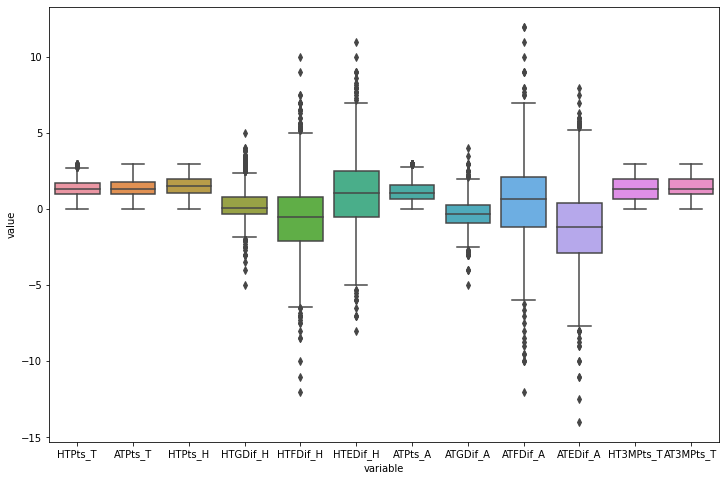

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x="variable", y="value", data=pd.melt(df_completo_pos3[['HTPts_T', 'ATPts_T', 'HTPts_H', 'HTGDif_H', 'HTFDif_H', 'HTEDif_H', 'ATPts_A', 'ATGDif_A', 'ATFDif_A', 'ATEDif_A', 'HT3MPts_T', 'AT3MPts_T']]))
plt.show()

In [8]:
#Verificação da necessidade de normalizar os dados
df_completo_pos3.describe().T

,count,mean,std,min,25%,50%,75%,max
FTR_H_NH,2450.0,0.466531,0.498980,0.0,0.0,0.0,1.0,1.0
HTPts_T,2450.0,1.366082,0.543288,0.0,1.0,1.3,1.7,3.0
ATPts_T,2450.0,1.385388,0.545151,0.0,1.0,1.3,1.8,3.0
HTPts_H,2450.0,1.546735,0.659590,0.0,1.1,1.5,2.0,3.0
HTGDif_H,2450.0,0.279673,0.974050,-5.0,-0.3,0.1,0.8,5.0
HTFDif_H,2450.0,-0.530367,2.373575,-12.0,-2.1,-0.5,0.8,10.0
HTEDif_H,2450.0,1.118898,2.301722,-8.0,-0.5,1.1,2.5,11.0
ATPts_A,2450.0,1.206816,0.658926,0.0,0.7,1.1,1.6,3.0
ATGDif_A,2450.0,-0.275592,0.948042,-5.0,-0.9,-0.3,0.3,4.0
ATFDif_A,2450.0,0.523837,2.582912,-12.0,-1.2,0.7,2.1,12.0


In [9]:
nro_partidas = len(df_completo_pos3.index)
nro_vitorias_mand = len(df_completo_pos3[df_completo_pos3.FTR_H_NH == 1])
perc_vitorias = (nro_vitorias_mand/nro_partidas) * 100

print('Número de partidas: ' + str(nro_partidas))
print('Número de vitórias do time mandante: ' + str(nro_vitorias_mand))
print('Porcentagem de vitórias: ' + str(round(perc_vitorias,2)))

Número de partidas: 2450
Número de vitórias do time mandante: 1143
Porcentagem de vitórias: 46.65


In [10]:
#Retornar configuração do matplotlib para default
mpl.rcParams.update(mpl.rcParamsDefault)

In [11]:
df_completo_pos3.groupby('FTR_H_NH').mean()

,HTPts_T,ATPts_T,HTPts_H,HTGDif_H,HTFDif_H,HTEDif_H,ATPts_A,ATGDif_A,ATFDif_A,ATEDif_A,HT3MPts_T,AT3MPts_T
FTR_H_NH,,,,,,,,,,,,
0,1.238715,1.498087,1.430451,0.076282,-0.517445,0.697552,1.320505,-0.103979,0.471232,-0.680031,1.228692,1.541316
1,1.511724,1.256518,1.679703,0.512248,-0.545144,1.600700,1.076815,-0.471829,0.583990,-1.648819,1.452406,1.262992


In [12]:
#Função utilizada para calcular o porcentual de vitórias do time mandante a partir de determinado limite e determinada variável
limite = 2

vars = ['HTPts_T']

for i in range(len(vars)):
    qtd_H1 = df_completo_pos3['FTR_H_NH'][(df_completo_pos3['FTR_H_NH'] == 1) & (df_completo_pos3[vars[i]] <= limite)].count()
    qtd_NH1 = df_completo_pos3['FTR_H_NH'][(df_completo_pos3['FTR_H_NH'] == 0) & (df_completo_pos3[vars[i]] <= limite)].count()
    total1 = qtd_H1 + qtd_NH1
    
    qtd_H2 = df_completo_pos3['FTR_H_NH'][(df_completo_pos3['FTR_H_NH'] == 1) & (df_completo_pos3[vars[i]] >= limite)].count()
    qtd_NH2 = df_completo_pos3['FTR_H_NH'][(df_completo_pos3['FTR_H_NH'] == 0) & (df_completo_pos3[vars[i]] >= limite)].count()
    total2 = qtd_H2 + qtd_NH2    

    print('% H<:', str(round(qtd_H1*100/total1,1)), '  Quantidade de partidas:', str(total1))
    print('% H>:', str(round(qtd_H2*100/total2,1)), '  Quantidade de partidas:', str(total2))

% H<: 43.3   Quantidade de partidas: 2150
% H>: 69.3   Quantidade de partidas: 414


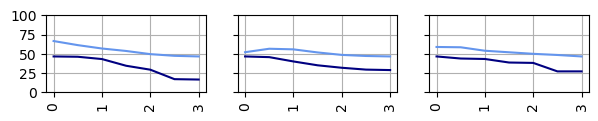

In [13]:
#Função para criar os gráficos do porcentual de vitórias do time mandante para valores maiores ou menores das variáveis
limite = list(np.arange(0, 3.1, 0.5))

vars = ['ATPts_T',
        'ATPts_A',
        'AT3MPts_T']

fig, ax = plt.subplots(1, len(vars), sharey='row', figsize=(7, 1))

for i in range(len(vars)):
    result1 = []
    result2 = []
    
    for lim in limite:
        qtd_H = df_completo_pos3['FTR_H_NH'][(df_completo_pos3['FTR_H_NH'] == 1) & (df_completo_pos3[vars[i]] >= lim)].count()
        qtd_NH = df_completo_pos3['FTR_H_NH'][(df_completo_pos3['FTR_H_NH'] == 0) & (df_completo_pos3[vars[i]] >= lim)].count()
        total = qtd_H + qtd_NH
        result1.append(round(qtd_H*100/total,1))

        qtd_H = df_completo_pos3['FTR_H_NH'][(df_completo_pos3['FTR_H_NH'] == 1) & (df_completo_pos3[vars[i]] <= lim)].count()
        qtd_NH = df_completo_pos3['FTR_H_NH'][(df_completo_pos3['FTR_H_NH'] == 0) & (df_completo_pos3[vars[i]] <= lim)].count()
        total = qtd_H + qtd_NH
        result2.append(round(qtd_H*100/total,1))        
    
    x_values = limite
    y_values1 = result1
    y_values2 = result2
    ax[i].set_ylim([0,100])
    ax[i].plot(x_values,y_values1, color='navy')
    ax[i].plot(x_values,y_values2, color='cornflowerblue')
    ax[i].set_xticks(np.arange(0, 4, 1))
    ax[i].set_yticks(np.arange(0, 101, 25))
    ax[i].set_xticklabels(ax[i].get_xticks(), rotation = 90)
    ax[i].grid()    

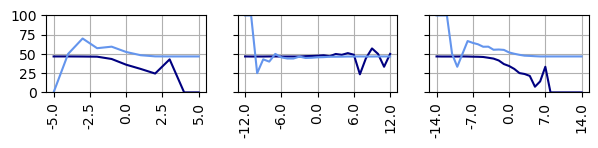

In [14]:
#Função para criar os gráficos do porcentual de vitórias do time mandante para valores maiores ou menores das variáveis
limite = [list(np.arange(-5, 6, 1)), list(np.arange(-12, 13, 1)), list(np.arange(-14, 15, 1))]

vars = ['ATGDif_A',
        'ATFDif_A',
        'ATEDif_A']

fig, ax = plt.subplots(1, len(vars), sharey='row', figsize=(7, 1))

titles = ['≥ valor', '≤ valor']

for i in range(len(vars)):
    result1 = []
    result2 = []
    
    for lim in limite[i]:
        qtd_H = df_completo_pos3['FTR_H_NH'][(df_completo_pos3['FTR_H_NH'] == 1) & (df_completo_pos3[vars[i]] >= lim)].count()
        qtd_NH = df_completo_pos3['FTR_H_NH'][(df_completo_pos3['FTR_H_NH'] == 0) & (df_completo_pos3[vars[i]] >= lim)].count()
        total = qtd_H + qtd_NH
        if total<0.001:
            total = 0.001
        result1.append(round(qtd_H*100/total,1))

        qtd_H = df_completo_pos3['FTR_H_NH'][(df_completo_pos3['FTR_H_NH'] == 1) & (df_completo_pos3[vars[i]] <= lim)].count()
        qtd_NH = df_completo_pos3['FTR_H_NH'][(df_completo_pos3['FTR_H_NH'] == 0)& (df_completo_pos3[vars[i]] <= lim)].count()
        total = qtd_H + qtd_NH
        if total<0.001:
            total = 0.001
        result2.append(round(qtd_H*100/total,1))        
    
    x_values = limite[i]
    y_values1 = result1
    y_values2 = result2
    ax[i].set_ylim([0,100])
    ax[i].plot(x_values,y_values1, color='navy')
    ax[i].plot(x_values,y_values2, color='cornflowerblue')
    ax[i].set_xticks(np.arange(limite[i][0], limite[i][-1]+1, 2*limite[i][-1]/4))
    ax[i].set_yticks(np.arange(0, 101, 25))
    ax[i].set_xticklabels(ax[i].get_xticks(), rotation = 90)
    ax[i].grid()
#    ax[i].legend(titles) 

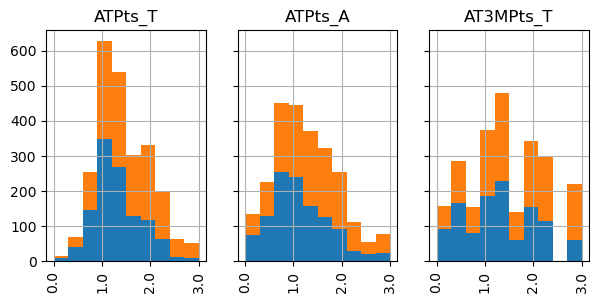

In [15]:
#Função utilizada para criar os gráficos de distribuição de frequências das variáveis
vars = ['ATPts_T',
        'ATPts_A',
        'AT3MPts_T']

fig, ax = plt.subplots(1, len(vars), sharey='row', figsize=(7, 3))
n = 2

titles = ['H', 'NH']

for i in range(len(vars)):
    df1 = (df_completo_pos3[df_completo_pos3['FTR_H_NH'] == 1][vars[i]])
    df2 = (df_completo_pos3[df_completo_pos3['FTR_H_NH'] == 0][vars[i]])
    ax[i].hist([df1, df2], stacked=True, bins=10)
    ax[i].set_title(vars[i])
#    ax[i].legend(titles) 
    minimo = abs(min(df2.min(), df1.min()))
    maximo = abs(max(df2.max(), df1.max()))
    limite = max(minimo, maximo)
    ax[i].grid()
    if minimo == 0:
        ax[i].set_xticks(np.arange(0, limite+1, 2*limite/6))
    else:
        ax[i].set_xticks(np.arange(-limite, limite+1, 2*limite/4))
    ax[i].set_xticklabels(ax[i].get_xticks(), rotation = 90)
    

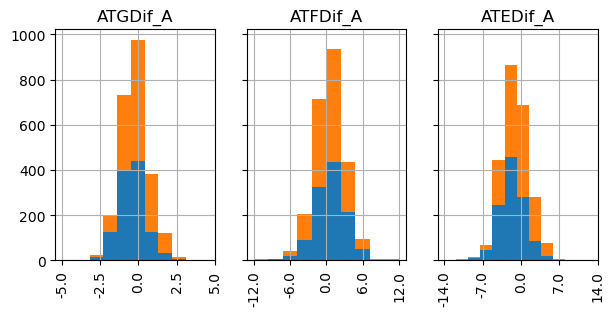

In [16]:
#Função utilizada para criar os gráficos de distribuição de frequências das variáveis
vars = ['ATGDif_A',
        'ATFDif_A',
        'ATEDif_A']

fig, ax = plt.subplots(1, len(vars), sharey='row', figsize=(7, 3))
n = 2

titles = ['H', 'NH']

for i in range(len(vars)):
    df1 = (df_completo_pos3[df_completo_pos3['FTR_H_NH'] == 1][vars[i]])
    df2 = (df_completo_pos3[df_completo_pos3['FTR_H_NH'] == 0][vars[i]])
    ax[i].hist([df1, df2], stacked=True, bins=10)
    ax[i].set_title(vars[i])
#    ax[i].legend(titles)
    minimo = abs(min(df2.min(), df1.min()))
    maximo = abs(max(df2.max(), df1.max()))
    limite = max(minimo, maximo)
    ax[i].grid()    
    if minimo == 0:
        ax[i].set_xticks(np.arange(0, limite+1, 2*limite/6))
    else:
        ax[i].set_xticks(np.arange(-limite, limite+1, 2*limite/4))
    ax[i].set_xticklabels(ax[i].get_xticks(), rotation = 90)

In [17]:
#Definir a variável target

x_features = df_completo_pos3.drop(['FTR_H_NH'],1)
y_target = df_completo_pos3[['FTR_H_NH', 'Temporada']]

In [18]:
#Definir dataframe de treinamento e de teste

temporada_treinamento = ['2013_2014', '2014_2015', '2015_2016', '2017_2018', '2018_2019']

x_train = x_features[(x_features['Temporada'].isin(temporada_treinamento))]
x_train = x_train.drop(columns=['Temporada'])

x_test = x_features[~(x_features['Temporada'].isin(temporada_treinamento))]
x_test = x_test.drop(columns=['Temporada'])

y_train = y_target[(y_target['Temporada'].isin(temporada_treinamento))]
y_train = y_train.drop(columns=['Temporada'])
y_train = y_train.squeeze()                       #Transformar Dataframe em Series

y_test = y_target[~(y_target['Temporada'].isin(temporada_treinamento))]
y_test = y_test.drop(columns=['Temporada'])
y_test = y_test.squeeze()                         #Transformar Dataframe em Series

In [19]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(1750, 12) (700, 12)
(1750,) (700,)


# 4. Criação dos modelos de Machine Learning

## 4.1. Regressão Logística

In [20]:
LR = LogisticRegression(random_state = 4, solver='lbfgs')

### Treinamento utilizando-se todas as variáveis disponíveis

In [21]:
#Treinar modelo com as informações do banco de dados inicial
LR.fit(x_train, y_train)

LogisticRegression(random_state=4)

In [22]:
intercept = LR.intercept_
coef = LR.coef_

print('O intercepto é ' + str(intercept))
print('Os coeficientes são ' + str(coef))

O intercepto é [-0.20090831]
Os coeficientes são [[ 1.08284357 -0.53876027 -0.79773953  0.52592136  0.02014304  0.0911906
   0.33001006 -0.24828561  0.01890034 -0.10313425 -0.10476853 -0.12852565]]


In [23]:
def resultado(descricao, modelo, x_train, y_train, x_test, y_test):
    
    train_test = {'train':[x_train, y_train], 'test':[x_test, y_test]}
    
    lista_result = [descricao]
    
    for sit in ['train', 'test']:
        matriz_confusao = confusion_matrix(train_test[sit][1], modelo.predict(train_test[sit][0]))

        true_positive = matriz_confusao[0,0]
        false_negative = matriz_confusao[0,1]
        false_positive = matriz_confusao[1,0]
        true_negative = matriz_confusao[1,1]

        acuracia = (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
        precisao = true_positive/(true_positive + false_positive)
        recall = true_positive/(true_positive + false_negative)
        f1_score = 2*(precisao * recall)/(precisao + recall)
        
        lista_result.append(round(acuracia,2))
        lista_result.append(round(f1_score,2))
    
    return lista_result

In [24]:
resultados = pd.DataFrame(columns=['Descrição', 'Acurácia (treino)', 'F1-Score (treino)', 'Acurácia (teste)', 'F1-Score (teste)'])

In [25]:
to_append = resultado('Banco de Dados Inicial', LR, x_train, y_train, x_test, y_test)
a_series = pd.Series(to_append, index = resultados.columns)
resultados = resultados.append(a_series, ignore_index=True)
resultados

,Descrição,Acurácia (treino),F1-Score (treino),Acurácia (teste),F1-Score (teste)
0,Banco de Dados Inicial,0.66,0.7,0.65,0.69


In [26]:
confusion_matrix(y_test, LR.predict(x_test))

array([[275,  87],
       [157, 181]], dtype=int64)

### Seleção de Variáveis

In [27]:
intercept = LR.intercept_
coef = LR.coef_

print('O intercepto é ' + str(intercept))
print('Os coeficientes são ' + str(coef))

O intercepto é [-0.20090831]
Os coeficientes são [[ 1.08284357 -0.53876027 -0.79773953  0.52592136  0.02014304  0.0911906
   0.33001006 -0.24828561  0.01890034 -0.10313425 -0.10476853 -0.12852565]]


In [28]:
y_pred = LR.predict(x_train)

In [29]:
F, p_value = feature_selection.f_regression(x_train, y_train)

In [30]:
def signif(p):
    if  p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return 'not'

In [31]:
d_df = {'coef':list(LR.coef_[0]), 'F': list(F), 'p_value': list(p_value)}
dfr = pd.DataFrame(d_df, index = x_train.columns)
dfr['significativo'] = dfr['p_value'].map(signif)                  # aplica função a uma Series
#dfr['chance'] = dfr.coef.map(chance)
#dfr['chance'] = dfr.coef.map(lambda ele: math.exp(ele))
dfr['razão de chance'] = pd.Series(np.exp(dfr.coef.values), x_train.columns)
#dfr['1/chance'] = 1 / dfr['razão de chance']
dfr['%'] = round((dfr['razão de chance'] - 1)*100,1)
dfr

#Coef: positivo: maior o valor, maior a chance
#      negativo: maior o valor, menor a chance
#Chance: maior que 1 indica que a chance aumenta
#        incremento de +1 unidade aumenta (se valor positivo) a chance em (chance - 1)%
#Interpretando HTPts_T: Coef positivo --> quanto maior, maior a chance
#                       chance --> a cada incremento de +1 unidade, a chance aumenta 2,95 vezes (295%) de vitória H

,coef,F,p_value,significativo,razão de chance,%
HTPts_T,1.082844,118.242958,1.074303e-26,***,2.953065,195.3
ATPts_T,-0.538760,86.425026,4.182084e-20,***,0.583471,-41.7
HTPts_H,-0.797740,64.607152,1.666977e-15,***,0.450346,-55.0
HTGDif_H,0.525921,96.864126,2.782751e-22,***,1.692017,69.2
HTFDif_H,0.020143,0.411208,5.214409e-01,not,1.020347,2.0
HTEDif_H,0.091191,70.332567,1.017728e-16,***,1.095478,9.5
ATPts_A,0.330010,55.020376,1.851160e-13,***,1.390982,39.1
ATGDif_A,-0.248286,61.552200,7.448034e-15,***,0.780137,-22.0
ATFDif_A,0.018900,1.030428,3.101987e-01,not,1.019080,1.9
ATEDif_A,-0.103134,64.458709,1.792600e-15,***,0.902006,-9.8


In [32]:
#VARIÁVEIS SELECIONADAS
cols = dfr[dfr['significativo'] != 'not'].index.values
cols

array(['HTPts_T', 'ATPts_T', 'HTPts_H', 'HTGDif_H', 'HTEDif_H', 'ATPts_A',
       'ATGDif_A', 'ATEDif_A', 'HT3MPts_T', 'AT3MPts_T'], dtype=object)

In [33]:
x_train_select = x_train[cols]
x_test_select = x_test[cols]

In [34]:
#Treinar modelo com as informações das variáveis selecionadas
LR.fit(x_train_select, y_train)

LogisticRegression(random_state=4)

In [35]:
to_append = resultado('Variáveis Selecionadas', LR, x_train_select, y_train, x_test_select, y_test)
a_series = pd.Series(to_append, index = resultados.columns)
resultados = resultados.append(a_series, ignore_index=True)
resultados

,Descrição,Acurácia (treino),F1-Score (treino),Acurácia (teste),F1-Score (teste)
0,Banco de Dados Inicial,0.66,0.7,0.65,0.69
1,Variáveis Selecionadas,0.66,0.7,0.66,0.70


In [36]:
intercept = LR.intercept_
coef = LR.coef_

print('O intercepto é ' + str(intercept))
print('Os coeficientes são ' + str(coef))

O intercepto é [-0.14102035]
Os coeficientes são [[ 1.07829786 -0.53748992 -0.81797931  0.54354671  0.08886523  0.31023492
  -0.23303811 -0.10357069 -0.1047637  -0.12777534]]


### Criar gráfico da função logística do modelo

In [37]:
#Probabilidades para classificar em H e NH para cada linha do df
probabilidades = LR.predict_proba(x_train_select)
probabilidades

array([[0.1659702 , 0.8340298 ],
       [0.50149408, 0.49850592],
       [0.43297434, 0.56702566],
       ...,
       [0.4700018 , 0.5299982 ],
       [0.48069495, 0.51930505],
       [0.56200732, 0.43799268]])

In [38]:
#Valores preditos
previsoes = LR.predict(x_train_select)
previsoes

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [39]:
gx_list = []

for i in range(len(x_train_select)):
    gx_aux = (sum(x_train_select.iloc[i].multiply(coef[0])) + intercept)[0]
    gx_list.append(gx_aux)

In [40]:
df_probabilidades = pd.DataFrame(probabilidades, columns = [0,1])
df_probabilidades['Previsão'] = previsoes.tolist()
df_probabilidades['Resultado'] = y_train.reset_index(drop=True)
df_probabilidades['gx'] = gx_list

def acerto(df_probabilidades):
    if df_probabilidades['Previsão'] == df_probabilidades['Resultado']:
        return 'Acertou'
    else:
        return 'Errou'
                                                          
df_probabilidades['Acerto'] = df_probabilidades.apply(acerto, axis=1)

def result(df_probabilidades):
    if df_probabilidades['Resultado'] == 1:
        return 1
    else:
        return 0
    
def prev(df_probabilidades):
    if df_probabilidades['Previsão'] == 1:
        return 1
    else:
        return 0    
    
df_probabilidades['Resultado_01'] = df_probabilidades.apply(result, axis=1)    
df_probabilidades['Previsão_01'] = df_probabilidades.apply(prev, axis=1)    

df_probabilidades

,0,1,Previsão,Resultado,gx,Acerto,Resultado_01,Previsão_01
0,0.165970,0.834030,1,0,1.614461,Errou,0,1
1,0.501494,0.498506,0,1,-0.005976,Errou,1,0
2,0.432974,0.567026,1,0,0.269726,Errou,0,1
3,0.849225,0.150775,0,0,-1.728536,Acertou,0,0
4,0.296096,0.703904,1,1,0.865958,Acertou,1,1
...,...,...,...,...,...,...,...,...
1745,0.280609,0.719391,1,1,0.941445,Acertou,1,1
1746,0.291519,0.708481,1,0,0.888020,Errou,0,1
1747,0.470002,0.529998,1,0,0.120137,Errou,0,1
1748,0.480695,0.519305,1,0,0.077259,Errou,0,1


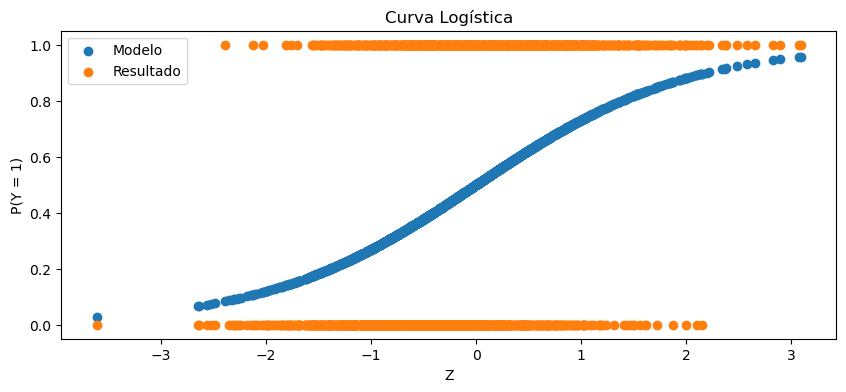

In [41]:
fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(df_probabilidades['gx'], df_probabilidades[1])
ax.scatter(df_probabilidades['gx'], df_probabilidades['Resultado'])

plt.title('Curva Logística')
plt.xlabel('Z')
plt.ylabel('P(Y = 1)')
plt.legend(['Modelo', 'Resultado'])

plt.show()

## 4.2. Árvore de Decisão

### Análise de overfitting

In [42]:
resultados = pd.DataFrame(columns=['Descrição', 'Acurácia (treino)', 'F1-Score (treino)', 'Acurácia (teste)', 'F1-Score (teste)', 'Níveis'])

for i in range(20):
    AD = DecisionTreeClassifier(max_depth = i+1, criterion = 'entropy')

    AD.fit(x_train, y_train)

    to_append = resultado('Árvore de Decisão', AD, x_train, y_train, x_test, y_test)
    to_append.append(i+1)
    a_series = pd.Series(to_append, index = resultados.columns)
    resultados = resultados.append(a_series, ignore_index=True)

In [43]:
resultados

,Descrição,Acurácia (treino),F1-Score (treino),Acurácia (teste),F1-Score (teste),Níveis
0,Árvore de Decisão,0.63,0.69,0.62,0.69,1
1,Árvore de Decisão,0.65,0.73,0.61,0.70,2
2,Árvore de Decisão,0.65,0.73,0.61,0.70,3
3,Árvore de Decisão,0.68,0.74,0.63,0.70,4
4,Árvore de Decisão,0.69,0.73,0.63,0.68,5
5,Árvore de Decisão,0.71,0.74,0.61,0.66,6
6,Árvore de Decisão,0.73,0.76,0.61,0.66,7
7,Árvore de Decisão,0.75,0.80,0.55,0.64,8
8,Árvore de Decisão,0.78,0.82,0.56,0.64,9
9,Árvore de Decisão,0.80,0.83,0.54,0.61,10


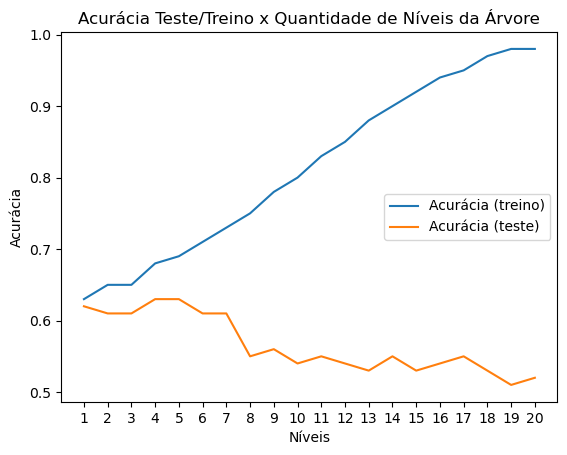

In [44]:
treino = resultados['Acurácia (treino)']
teste = resultados['Acurácia (teste)']
x = resultados['Níveis']
line_chart1 = plt.plot(x, treino)
line_chart2 = plt.plot(x, teste)
plt.title('Acurácia Teste/Treino x Quantidade de Níveis da Árvore')
plt.xlabel('Níveis')
plt.ylabel('Acurácia')
xint = range(min(x), math.ceil(max(x))+1)
plt.xticks(xint)
plt.legend(['Acurácia (treino)', 'Acurácia (teste)'], loc=5)
plt.show()

### Criar modelo com a quantidade de níveis definido na análise de overfitting

In [45]:
AD = DecisionTreeClassifier(max_depth = 4, criterion = 'gini')

In [46]:
#AD.fit(x_train_select, y_train)
AD.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [47]:
resultados = pd.DataFrame(columns=['Descrição', 'Acurácia (treino)', 'F1-Score (treino)', 'Acurácia (teste)', 'F1-Score (teste)'])

In [48]:
to_append = resultado('Árvore de Decisão', AD, x_train, y_train, x_test, y_test)
a_series = pd.Series(to_append, index = resultados.columns)
resultados = resultados.append(a_series, ignore_index=True)
resultados

,Descrição,Acurácia (treino),F1-Score (treino),Acurácia (teste),F1-Score (teste)
0,Árvore de Decisão,0.68,0.74,0.64,0.7


Variável: HTPts_T --> Score: 0.41940
Variável: ATPts_T --> Score: 0.26743
Variável: HTPts_H --> Score: 0.03953
Variável: HTGDif_H --> Score: 0.03504
Variável: HTFDif_H --> Score: 0.00000
Variável: HTEDif_H --> Score: 0.01686
Variável: ATPts_A --> Score: 0.00000
Variável: ATGDif_A --> Score: 0.03755
Variável: ATFDif_A --> Score: 0.01945
Variável: ATEDif_A --> Score: 0.16474
Variável: HT3MPts_T --> Score: 0.00000
Variável: AT3MPts_T --> Score: 0.00000


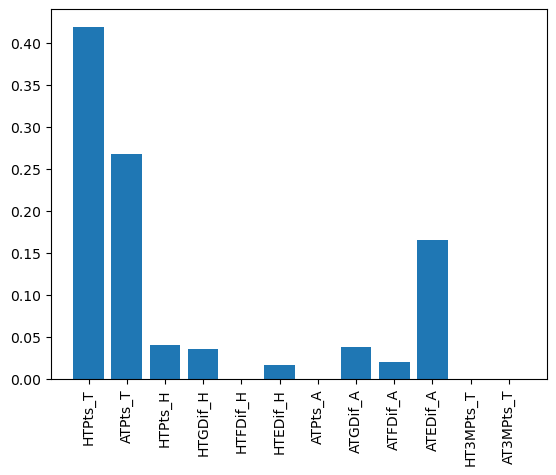

In [49]:
#Obter a importância das variáveis
importance = AD.feature_importances_
#Criar resumo com a importância das variáveis
for i,v in enumerate(importance):
    print('Variável:', x_train.columns[i], '--> Score: %.5f' % (v))
#Plotar a importância das variáveis
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], x_train.columns, rotation=90)
plt.show()

In [50]:
#Obter as variáveis que tiveram importância no modelo
dict_variavel_score = dict(zip(x_train.columns.values, importance))
sorted(dict_variavel_score.items(), key=lambda x:x[1])

[('HTFDif_H', 0.0),
 ('ATPts_A', 0.0),
 ('HT3MPts_T', 0.0),
 ('AT3MPts_T', 0.0),
 ('HTEDif_H', 0.016858587964516947),
 ('ATFDif_A', 0.019446165313908144),
 ('HTGDif_H', 0.03504109139103668),
 ('ATGDif_A', 0.037546313504789465),
 ('HTPts_H', 0.039532180355322806),
 ('ATEDif_A', 0.16474213465994075),
 ('ATPts_T', 0.267431487891664),
 ('HTPts_T', 0.41940203891882116)]

In [51]:
#Remover as variáveis que não tiveram importância no modelo
cols = ['HTPts_T', 'ATPts_T', 'ATEDif_A', 'HTPts_H', 'ATGDif_A', 'HTGDif_H', 'HTEDif_H', 'ATFDif_A']
x_train_select = x_train[cols]
x_test_select = x_test[cols]

In [52]:
AD.fit(x_train_select, y_train)

DecisionTreeClassifier(max_depth=4)

In [53]:
to_append = resultado('Árvore de Decisão - Select', AD, x_train_select, y_train, x_test_select, y_test)
a_series = pd.Series(to_append, index = resultados.columns)
resultados = resultados.append(a_series, ignore_index=True)
resultados

,Descrição,Acurácia (treino),F1-Score (treino),Acurácia (teste),F1-Score (teste)
0,Árvore de Decisão,0.68,0.74,0.64,0.7
1,Árvore de Decisão - Select,0.68,0.74,0.64,0.7


Variável: HTPts_T --> Score: 0.41962
Variável: ATPts_T --> Score: 0.26743
Variável: ATEDif_A --> Score: 0.16474
Variável: HTPts_H --> Score: 0.03953
Variável: ATGDif_A --> Score: 0.03755
Variável: HTGDif_H --> Score: 0.03504
Variável: HTEDif_H --> Score: 0.01664
Variável: ATFDif_A --> Score: 0.01945


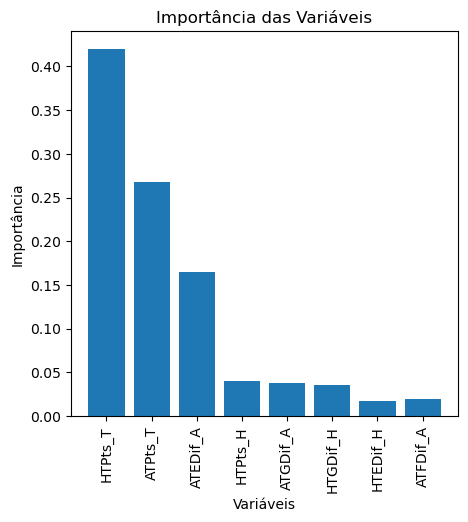

In [54]:
# get importance
importance = AD.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Variável:', x_train_select.columns[i], '--> Score: %.5f' % (v))
# plot feature importance
fig = plt.figure(figsize=(5,5))
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], x_train_select.columns, rotation=90)
plt.title('Importância das Variáveis')
plt.xlabel('Variáveis')
plt.ylabel('Importância')
plt.show()

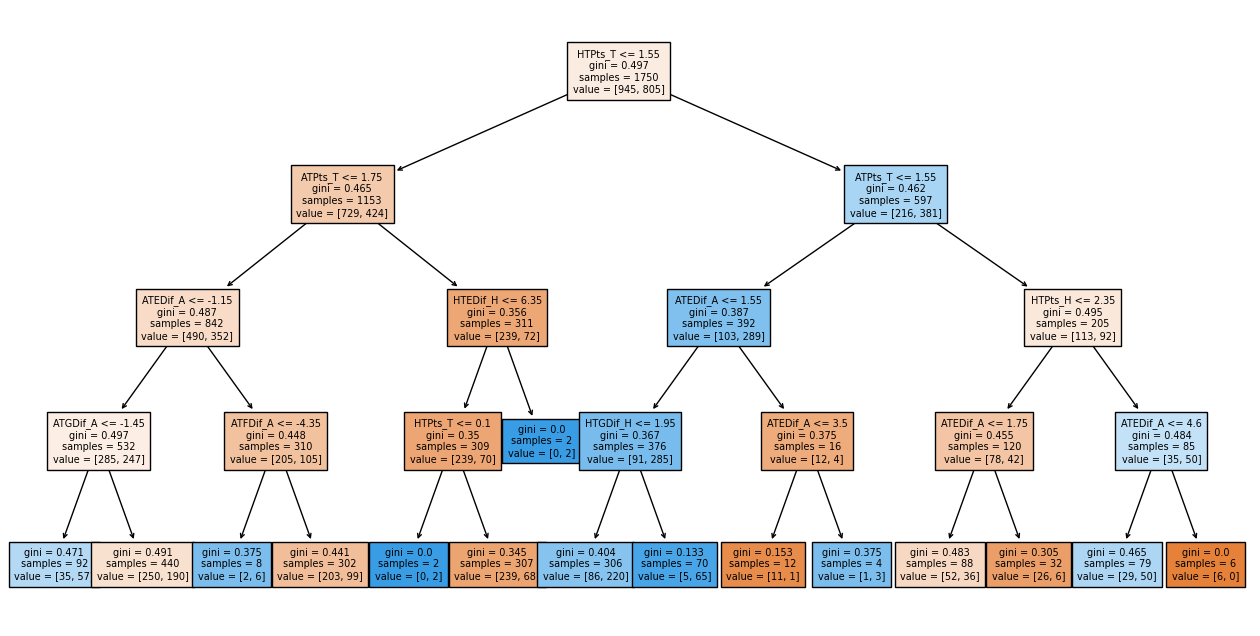

In [55]:
#Plotar a árvore de decisão obtida
fig = plt.figure(figsize=(16,8))
_ = tree.plot_tree(AD, filled=True, fontsize=7, feature_names=cols)

In [56]:
#Plotar a árvore de descisão em formato de texto
text_representation = tree.export_text(AD, feature_names=cols)
print(text_representation)

|--- HTPts_T <= 1.55
|   |--- ATPts_T <= 1.75
|   |   |--- ATEDif_A <= -1.15
|   |   |   |--- ATGDif_A <= -1.45
|   |   |   |   |--- class: 1
|   |   |   |--- ATGDif_A >  -1.45
|   |   |   |   |--- class: 0
|   |   |--- ATEDif_A >  -1.15
|   |   |   |--- ATFDif_A <= -4.35
|   |   |   |   |--- class: 1
|   |   |   |--- ATFDif_A >  -4.35
|   |   |   |   |--- class: 0
|   |--- ATPts_T >  1.75
|   |   |--- HTEDif_H <= 6.35
|   |   |   |--- HTPts_T <= 0.10
|   |   |   |   |--- class: 1
|   |   |   |--- HTPts_T >  0.10
|   |   |   |   |--- class: 0
|   |   |--- HTEDif_H >  6.35
|   |   |   |--- class: 1
|--- HTPts_T >  1.55
|   |--- ATPts_T <= 1.55
|   |   |--- ATEDif_A <= 1.55
|   |   |   |--- HTGDif_H <= 1.95
|   |   |   |   |--- class: 1
|   |   |   |--- HTGDif_H >  1.95
|   |   |   |   |--- class: 1
|   |   |--- ATEDif_A >  1.55
|   |   |   |--- ATEDif_A <= 3.50
|   |   |   |   |--- class: 0
|   |   |   |--- ATEDif_A >  3.50
|   |   |   |   |--- class: 1
|   |--- ATPts_T >  1.55
|   |   